In [1]:
# loading packages
import io
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.linear_model import Lasso
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
import itertools
import xgboost

In [3]:
# read the uploaded CSV file into a DataFrame using pandas
df = pd.read_csv('./Cleaned Data/Features and Target (Merged).csv')
df["forward_return"] = df["forward_return"]/100

In [4]:
##这一步是为了生成一个list list里面有四个元素，每个元素是个字典，字典里面保存了我们每次rolling period
##的开始时间 结束时间，training 和 Validation以及testing的时间节点
iteration_list = []
rolling_order = 1
for i in range(1993,2013,5):
    start_date = int(str(i) + "01")
    end_date = int(str(i+15) + "01")
    training_separation_date = int(str(i+10) + "01")
    Dic = {"start_date":start_date,"end_date":end_date,
           "training_separation_date":training_separation_date,"rolling_order":rolling_order}
    rolling_order = rolling_order + 1
    iteration_list.append(Dic)
print(iteration_list)

features =['News_sentiment_3MA', 'Consumer_sentiment_3MA', 'Investor_sentiment_3MA','betaVIX', 
           'BookLeverage', 'ConvDebt', 'DolVol', 'hire', 'IdioVol3F', 'IndMom', 'MaxRet',
           'OPLeverage', 'PctAcc', 'RDIPO', 'ReturnSkew', 'Size', 'STreversal','zerotradeAlt1']

[{'start_date': 199301, 'end_date': 200801, 'training_separation_date': 200301, 'rolling_order': 1}, {'start_date': 199801, 'end_date': 201301, 'training_separation_date': 200801, 'rolling_order': 2}, {'start_date': 200301, 'end_date': 201801, 'training_separation_date': 201301, 'rolling_order': 3}, {'start_date': 200801, 'end_date': 202301, 'training_separation_date': 201801, 'rolling_order': 4}]


In [5]:
Strategy_monthly_returns = []
for value in tqdm(iteration_list): ##对每一个rolling period进行相同的操作，也就是进行training，validation到testing
    ##对于每一个rolling period，从刚刚生成list当中的字典，获得他们的不同的节点，用于分割数据
    start_date = value["start_date"]
    end_date = value["end_date"]
    training_separation_date = value["training_separation_date"]
        
    
    ##开始根据节点 分割不同的periods
    sub_period = df[(df["yyyymm"]>=start_date)&(df["yyyymm"]<end_date)]
    sub_period = sub_period.dropna(subset = features)
    training_sample = sub_period[sub_period["yyyymm"]<training_separation_date].reset_index(drop=True)
    testing_sample = sub_period[sub_period["yyyymm"]>=training_separation_date].reset_index(drop=True)
    
   
    ##用最好模型对应的参数重新train一次模型
    best_model = xgboost.XGBRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=10,
                subsample=0.6,
                colsample_bytree=1,
                gamma=0.1,
                reg_lambda=0.5,
                objective='reg:squarederror',
                n_jobs=6
            )
    best_model.fit(training_sample[features],training_sample['forward_return'].values)
    
    ##计算一下在这个模型之下的features importance并保存
    ##Features_important = pd.DataFrame(best_model.feature_importances_, features,
             ##columns=["value"]).sort_values(["value"],ascending=False).head(10)
    
    ##print(Features_important)
    
    ##开始对testing sample进行处理，首先要拿到training sample的月份，变成一个list
    Month_list = list(testing_sample[["yyyymm"]].drop_duplicates().sort_values(by="yyyymm")["yyyymm"])
    

    Top_20_returns = []
    Top_10_returns = []
    Top_5_returns = []
    Random_returns = []
    #每个月用一次模型进行预测
    for month in Month_list:
        sub_testing_sample = testing_sample[testing_sample["yyyymm"]==month]
        testing_predicted = pd.DataFrame(best_model.predict(sub_testing_sample[features]))
        testing_realized = sub_testing_sample[["forward_return"]].reset_index(drop=True)
        testing_predicted_real = pd.concat([testing_predicted,testing_realized],axis=1)
        
        #predicted value 排序 选出最高的那20个equally weighted组成我们的portfolio
        top_five = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[-5:])/5
        top_ten = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[-10:])/10
        top_twenty = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[-20:])/20
        Random = sum(list(testing_predicted_real.sample(n=20, random_state=42)["forward_return"]))/20
        ##bottom_twenty = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[:20])/20
        
        ##存储每一个月的return到我们预先设置好的list
        Top_20_returns.append(top_twenty)
        Top_10_returns.append(top_ten)
        Top_5_returns.append(top_five)
        Random_returns.append(Random)
    
    Portfolio_monthly_return_each_testing_period = pd.DataFrame({"yyyymm":Month_list[1:],"Top_20_returns":Top_20_returns[:-1],
                                                                "Top_10_returns":Top_10_returns[:-1],"Top_5_returns":Top_5_returns[:-1],
                                                                "Random_returns":Random_returns[:-1]})
    Portfolio_monthly_return_each_testing_period["yyyymm"] = pd.to_datetime(Portfolio_monthly_return_each_testing_period['yyyymm'], format='%Y%m')
    Strategy_monthly_returns.append(Portfolio_monthly_return_each_testing_period)

Strategy_monthly_returns = pd.concat(Strategy_monthly_returns,axis = 0)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


In [6]:
Strategy_monthly_returns['Top_20_Cumulative_Return'] = (1 + Strategy_monthly_returns['Top_20_returns']).cumprod() - 1
Strategy_monthly_returns['Top_10_Cumulative_Return'] = (1 + Strategy_monthly_returns['Top_10_returns']).cumprod() - 1
Strategy_monthly_returns['Top_5_Cumulative_Return'] = (1 + Strategy_monthly_returns['Top_5_returns']).cumprod() - 1
Strategy_monthly_returns['Random_Cumulative_Return'] = (1 + Strategy_monthly_returns['Random_returns']).cumprod() - 1

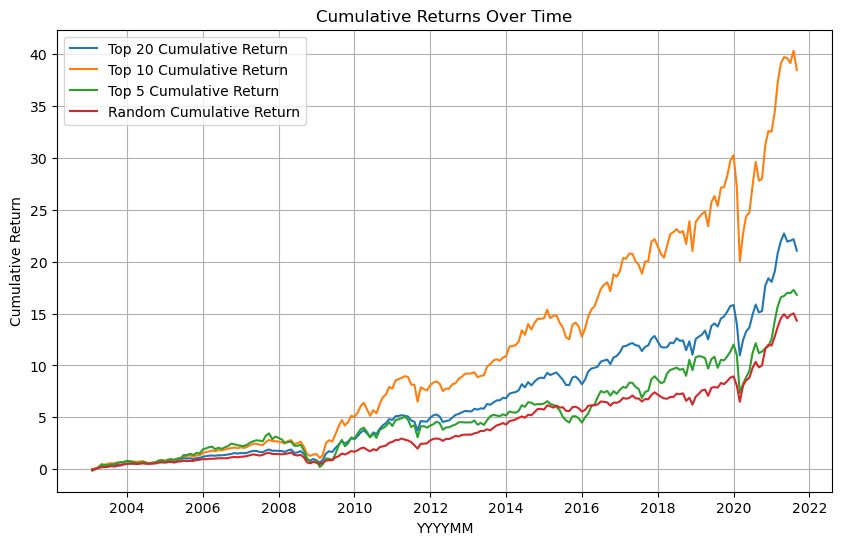

In [7]:
plt.figure(figsize=(10, 6))
Strategy_monthly_returns.set_index('yyyymm', inplace=True)
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Top_20_Cumulative_Return'], label='Top 20 Cumulative Return')
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Top_10_Cumulative_Return'], label='Top 10 Cumulative Return')
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Top_5_Cumulative_Return'], label='Top 5 Cumulative Return')
plt.plot(Strategy_monthly_returns.index, Strategy_monthly_returns['Random_Cumulative_Return'], label='Random Cumulative Return')

# Customize the plot
plt.title('Cumulative Returns Over Time')
plt.xlabel('YYYYMM')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()